In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#    -O /tmp/sunspots.csv

--2019-07-02 23:12:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-07-02 23:12:42 (116 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



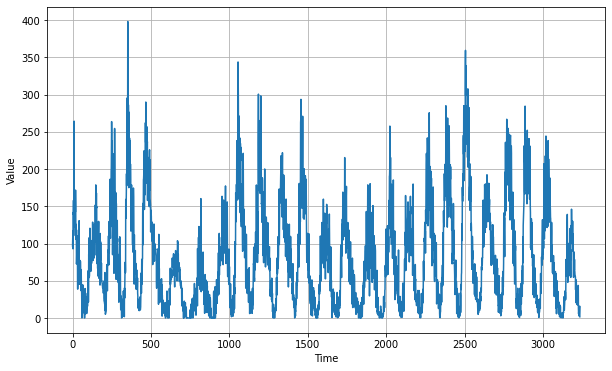

In [3]:
import csv
time_step = []
sunspots = []

with open('../../data/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

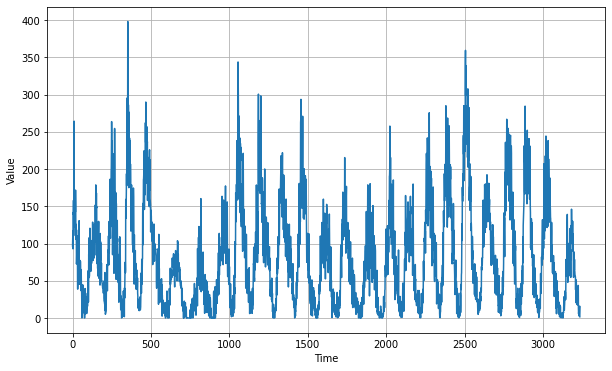

In [4]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 3s 19ms/step - loss: 78.5293 - mae: 79.0250
Epoch 2/100
12/12 [==============================] - 0s 23ms/step - loss: 78.8045 - mae: 79.3003
Epoch 3/100
12/12 [==============================] - 0s 23ms/step - loss: 79.1779 - mae: 79.6735
Epoch 4/100
12/12 [==============================] - 0s 23ms/step - loss: 78.0048 - mae: 78.5008
Epoch 5/100
12/12 [==============================] - 0s 21ms/step - loss: 77.4860 - mae: 77.9818
Epoch 6/100
12/12 [==============================] - 0s 23ms/step - loss: 77.4808 - mae: 77.9770
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 77.6363 - mae: 78.1324
Epoch 8/100
12/12 [==============================] - 0s 22ms/step - loss: 76.9970 - mae: 77.4933
Epoch 9/100
12/12 [==============================] - 0s 22ms/step - loss: 76.4467 - mae: 76.9431
Epoch 10/100
12/12 [=====

12/12 [==============================] - 0s 23ms/step - loss: 21.2493 - mae: 21.7429
Epoch 84/100
12/12 [==============================] - 0s 23ms/step - loss: 20.2194 - mae: 20.7123
Epoch 85/100
12/12 [==============================] - 0s 22ms/step - loss: 20.6971 - mae: 21.1896
Epoch 86/100
12/12 [==============================] - 0s 23ms/step - loss: 20.5221 - mae: 21.0156
Epoch 87/100
12/12 [==============================] - 0s 23ms/step - loss: 37.7727 - mae: 38.2687
Epoch 88/100
12/12 [==============================] - 0s 23ms/step - loss: 40.1901 - mae: 40.6864
Epoch 89/100
12/12 [==============================] - 0s 23ms/step - loss: 48.0916 - mae: 48.5893
Epoch 90/100
12/12 [==============================] - 0s 22ms/step - loss: 45.2325 - mae: 45.7298
Epoch 91/100
12/12 [==============================] - 0s 22ms/step - loss: 45.4249 - mae: 45.9224
Epoch 92/100
12/12 [==============================] - 0s 23ms/step - loss: 47.7941 - mae: 48.2913
Epoch 93/100
12/12 [=============

(1e-08, 0.0001, 0.0, 60.0)

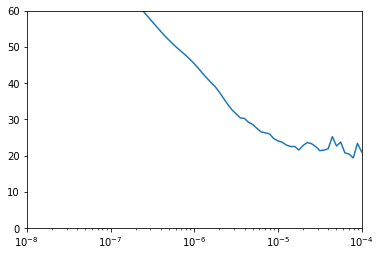

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 12ms/step - loss: 47.7134 - mae: 48.2106
Epoch 2/500
30/30 [==============================] - 0s 11ms/step - loss: 26.8675 - mae: 27.3624
Epoch 3/500
30/30 [==============================] - 0s 11ms/step - loss: 22.9762 - mae: 23.4707
Epoch 4/500
30/30 [==============================] - 0s 11ms/step - loss: 20.2706 - mae: 20.7637
Epoch 5/500
30/30 [==============================] - 0s 12ms/step - loss: 19.3907 - mae: 19.8832
Epoch 6/500
30/30 [==============================] - 0s 11ms/step - loss: 19.4453 - mae: 19.9376
Epoch 7/500
30/30 [==============================] - 0s 11ms/step - loss: 18.5720 - mae: 19.0637
Epoch 8/500
30/30 [==============================] - 0s 11ms/step - loss: 18.0353 - mae: 18.5265
Epoch 9/500
30/30 [==============================] - 0s 11ms/step - loss: 17.9571 - mae: 18.4483
Epoch 10/500
30/30 [==============================] - 0s 12ms/step - loss: 17.8588 - mae: 18.3499
Epoch 11/500
30/30 [=========

30/30 [==============================] - 0s 11ms/step - loss: 16.2244 - mae: 16.7120
Epoch 85/500
30/30 [==============================] - 0s 13ms/step - loss: 16.1335 - mae: 16.6210
Epoch 86/500
30/30 [==============================] - 0s 11ms/step - loss: 16.5992 - mae: 17.0868
Epoch 87/500
30/30 [==============================] - 0s 11ms/step - loss: 16.5754 - mae: 17.0639
Epoch 88/500
30/30 [==============================] - 0s 11ms/step - loss: 16.1762 - mae: 16.6639
Epoch 89/500
30/30 [==============================] - 0s 11ms/step - loss: 16.3900 - mae: 16.8780
Epoch 90/500
30/30 [==============================] - 0s 12ms/step - loss: 16.0641 - mae: 16.5516
Epoch 91/500
30/30 [==============================] - 0s 11ms/step - loss: 16.0316 - mae: 16.5197
Epoch 92/500
30/30 [==============================] - 0s 11ms/step - loss: 16.1843 - mae: 16.6720
Epoch 93/500
30/30 [==============================] - 0s 12ms/step - loss: 16.2808 - mae: 16.7687
Epoch 94/500
30/30 [=============

30/30 [==============================] - 0s 11ms/step - loss: 15.5690 - mae: 16.0566
Epoch 168/500
30/30 [==============================] - 0s 11ms/step - loss: 15.6651 - mae: 16.1531
Epoch 169/500
30/30 [==============================] - 0s 12ms/step - loss: 15.4840 - mae: 15.9714
Epoch 170/500
30/30 [==============================] - 0s 12ms/step - loss: 15.5631 - mae: 16.0506
Epoch 171/500
30/30 [==============================] - 0s 11ms/step - loss: 15.5977 - mae: 16.0857
Epoch 172/500
30/30 [==============================] - 0s 11ms/step - loss: 15.6861 - mae: 16.1741
Epoch 173/500
30/30 [==============================] - 0s 13ms/step - loss: 15.6977 - mae: 16.1858
Epoch 174/500
30/30 [==============================] - 0s 12ms/step - loss: 15.6820 - mae: 16.1694
Epoch 175/500
30/30 [==============================] - 0s 12ms/step - loss: 15.7753 - mae: 16.2636
Epoch 176/500
30/30 [==============================] - 0s 11ms/step - loss: 15.6466 - mae: 16.1341
Epoch 177/500
30/30 [===

30/30 [==============================] - 0s 11ms/step - loss: 15.3145 - mae: 15.8020
Epoch 250/500
30/30 [==============================] - 0s 11ms/step - loss: 15.3915 - mae: 15.8787
Epoch 251/500
30/30 [==============================] - 0s 11ms/step - loss: 15.3295 - mae: 15.8162
Epoch 252/500
30/30 [==============================] - 0s 11ms/step - loss: 15.5244 - mae: 16.0116
Epoch 253/500
30/30 [==============================] - 0s 12ms/step - loss: 15.1682 - mae: 15.6546
Epoch 254/500
30/30 [==============================] - 0s 11ms/step - loss: 15.1667 - mae: 15.6533
Epoch 255/500
30/30 [==============================] - 0s 12ms/step - loss: 15.1209 - mae: 15.6073
Epoch 256/500
30/30 [==============================] - 0s 11ms/step - loss: 15.0508 - mae: 15.5375
Epoch 257/500
30/30 [==============================] - 0s 11ms/step - loss: 15.3245 - mae: 15.8113
Epoch 258/500
30/30 [==============================] - 0s 12ms/step - loss: 15.1059 - mae: 15.5922
Epoch 259/500
30/30 [===

30/30 [==============================] - 0s 11ms/step - loss: 14.7875 - mae: 15.2736
Epoch 332/500
30/30 [==============================] - 0s 11ms/step - loss: 14.7891 - mae: 15.2743
Epoch 333/500
30/30 [==============================] - 0s 12ms/step - loss: 15.0810 - mae: 15.5671
Epoch 334/500
30/30 [==============================] - 0s 11ms/step - loss: 14.9597 - mae: 15.4463
Epoch 335/500
30/30 [==============================] - 0s 12ms/step - loss: 14.8596 - mae: 15.3450
Epoch 336/500
30/30 [==============================] - 0s 11ms/step - loss: 14.8370 - mae: 15.3226
Epoch 337/500
30/30 [==============================] - 0s 11ms/step - loss: 14.9920 - mae: 15.4783
Epoch 338/500
30/30 [==============================] - 0s 12ms/step - loss: 14.9274 - mae: 15.4125
Epoch 339/500
30/30 [==============================] - 0s 12ms/step - loss: 14.8301 - mae: 15.3159
Epoch 340/500
30/30 [==============================] - 0s 11ms/step - loss: 14.7607 - mae: 15.2467
Epoch 341/500
30/30 [===

30/30 [==============================] - 0s 13ms/step - loss: 14.6048 - mae: 15.0893
Epoch 414/500
30/30 [==============================] - 0s 11ms/step - loss: 14.6203 - mae: 15.1053
Epoch 415/500
30/30 [==============================] - 0s 11ms/step - loss: 14.5122 - mae: 14.9964
Epoch 416/500
30/30 [==============================] - 0s 11ms/step - loss: 14.9096 - mae: 15.3955
Epoch 417/500
30/30 [==============================] - 0s 12ms/step - loss: 14.6859 - mae: 15.1718
Epoch 418/500
30/30 [==============================] - 0s 12ms/step - loss: 14.6287 - mae: 15.1138
Epoch 419/500
30/30 [==============================] - 0s 11ms/step - loss: 14.5339 - mae: 15.0185
Epoch 420/500
30/30 [==============================] - 0s 13ms/step - loss: 14.6527 - mae: 15.1376
Epoch 421/500
30/30 [==============================] - 0s 12ms/step - loss: 14.3750 - mae: 14.8598
Epoch 422/500
30/30 [==============================] - 0s 12ms/step - loss: 14.4237 - mae: 14.9080
Epoch 423/500
30/30 [===

30/30 [==============================] - 0s 11ms/step - loss: 14.2831 - mae: 14.7670
Epoch 496/500
30/30 [==============================] - 0s 11ms/step - loss: 14.3020 - mae: 14.7869
Epoch 497/500
30/30 [==============================] - 0s 11ms/step - loss: 14.4046 - mae: 14.8896
Epoch 498/500
30/30 [==============================] - 0s 12ms/step - loss: 14.2009 - mae: 14.6853
Epoch 499/500
30/30 [==============================] - 0s 11ms/step - loss: 14.5997 - mae: 15.0853
Epoch 500/500
30/30 [==============================] - 0s 11ms/step - loss: 14.4284 - mae: 14.9134


In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

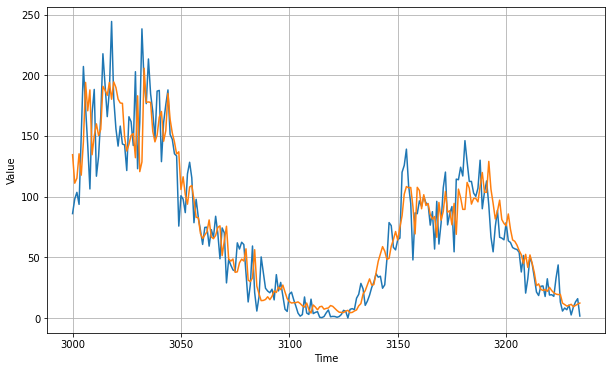

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.300522

<Figure size 432x288 with 0 Axes>

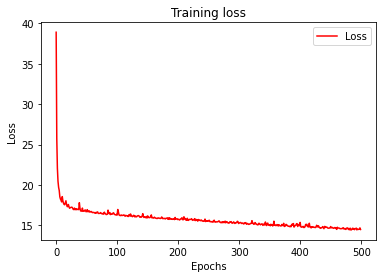

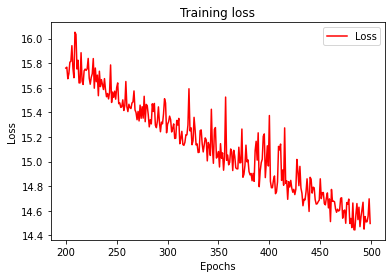

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[134.52075   111.04022   115.20326   135.27582   117.65578   145.20479
 194.09825   170.70985   187.90347   134.471     149.95398   159.94835
 150.27602   155.42747   190.84935   187.61551   183.40283   194.04597
 180.22282   194.47937   189.87794   180.33914   177.16534   176.84148
 149.20667   137.53764   143.03128   150.40036   151.93185   132.0472
 183.03285   120.58453   128.60811   205.75189   177.7404    177.98962
 177.62306   153.7601    145.11061   150.71027   165.40189   170.128
 145.61644   154.28734   185.0121    163.65001   152.44275   145.00877
 135.10287   136.90338   105.82638   116.33246   101.75317    93.74358
 107.924774  109.11098    97.47912    82.98602    82.57368    69.62297
  65.5106     68.28989    71.06766    80.77588    66.72188    65.33068
  68.02718    74.60628    75.90719    51.36082    63.379967   75.5822
  48.73602    46.87125    48.575844   37.603485   38.031147   45.453964
  48.466206   46.897675   56.982136   31.200848   29.992193   33.03783
  56.2431